**3.**

In [ ]:
# add skip connection

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.datasets import cifar100
from tensorflow.keras import regularizers, optimizers
import numpy as np


### full code - add skip connection and increase filters ###

(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std  = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test  = (x_test-mean)/(std+1e-7)

baseMapNum = 32
weight_decay = 1e-5

# model
inputs = tf.keras.Input(shape=(32, 32, 3))
x = inputs

# block 1
previous = x

x = Conv2D(64, (3,3), padding='same', activation='relu', 
           kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay))(x)
x = tfa.layers.InstanceNormalization()(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), padding='same', activation='relu', 
           kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay))(x)
x = tfa.layers.InstanceNormalization()(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), padding='same', activation='relu', 
           kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay))(x)
x = tfa.layers.InstanceNormalization()(x)
x = BatchNormalization()(x)

x = keras.layers.concatenate([x, previous]) 

x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.3)(x)


# block 2
previous = x

x = Conv2D(128, (3,3), padding='same', activation='relu', 
           kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay))(x)
x = tfa.layers.InstanceNormalization()(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3,3), padding='same', activation='relu', 
           kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay))(x)
x = tfa.layers.InstanceNormalization()(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3,3), padding='same', activation='relu', 
           kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay))(x)
x = tfa.layers.InstanceNormalization()(x)
x = BatchNormalization()(x)

x = keras.layers.concatenate([x, previous]) 

x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.3)(x)


# block 3
previous = x

x = Conv2D(256, (3,3), padding='same', activation='relu', 
           kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay))(x)
x = tfa.layers.InstanceNormalization()(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3,3), padding='same', activation='relu', 
           kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay))(x)
x = tfa.layers.InstanceNormalization()(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3,3), padding='same', activation='relu', 
           kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay))(x)
x = tfa.layers.InstanceNormalization()(x)
x = BatchNormalization()(x)

x = keras.layers.concatenate([x, previous]) 

x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.4)(x)


# block 4
previous = x

x = Conv2D(512, (3,3), padding='same', activation='relu', 
           kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay))(x)
x = tfa.layers.InstanceNormalization()(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3,3), padding='same', activation='relu', 
           kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay))(x)
x = tfa.layers.InstanceNormalization()(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3,3), padding='same', activation='relu', 
           kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay))(x)
x = tfa.layers.InstanceNormalization()(x)
x = BatchNormalization()(x)

x = keras.layers.concatenate([x, previous]) 

x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.4)(x)

# block 5
previous = x

x = Conv2D(512, (3,3), padding='same', activation='relu', 
           kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay))(x)
x = tfa.layers.InstanceNormalization()(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3,3), padding='same', activation='relu', 
           kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay))(x)
x = tfa.layers.InstanceNormalization()(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3,3), padding='same', activation='relu', 
           kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay))(x)
x = tfa.layers.InstanceNormalization()(x)
x = BatchNormalization()(x)

x = keras.layers.concatenate([x, previous]) 

x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.4)(x)

# dense block 

x = Flatten()(x)
# x = Dense(1024)(x)
x = Dense(512)(x)
outputs = keras.layers.Dense(100, activation='softmax')(x)

model = keras.Model(inputs, outputs)

#training
batch_size = 256
epochs = 2500
steps = x_train.shape[0] // batch_size

boundaries = [steps*70, steps*110]
values = [0.001, 0.0005, 0.0001]
schedules = keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
opt_adam  = keras.optimizers.Adam(learning_rate=schedules)


# data augmentation
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset  = tf.data.Dataset.from_tensor_slices((x_test, y_test))

def process_data(image, label):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.resize(image, (38, 38))
        image = tf.image.random_crop(image, size=[32, 32, 3])
      
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)

    return image, label

train_batches = (train_dataset.shuffle(256*4)
                              .map(process_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                              .batch(batch_size)
                              .prefetch(tf.data.experimental.AUTOTUNE) )

test_dataset = (test_dataset.batch(batch_size))

model.compile(loss='sparse_categorical_crossentropy', optimizer=opt_adam, metrics=['accuracy'])
history = model.fit(train_batches, validation_data=test_dataset, epochs=epochs, verbose=1)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
Epoch 1/2500
196/196 [==============================] - 23s 84ms/step - loss: 25.7075 - accuracy: 0.0117 - val_loss: 9.3154 - val_accuracy: 0.0100
Epoch 2/2500
196/196 [==============================] - 16s 78ms/step - loss: 9.1314 - accuracy: 0.0163 - val_loss: 9.4705 - val_accuracy: 0.0133
Epoch 3/2500
196/196 [==============================] - 16s 79ms/step - loss: 7.6064 - accuracy: 0.0232 - val_loss: 8.8383 - val_accuracy: 0.0105
Epoch 4/2500
196/196 [==============================] - 15s 78ms/step - loss: 7.0219 - accuracy: 0.0293 - val_loss: 8.1440 - val_accuracy: 0.0132
Epoch 5/2500
196/196 [==============================] - 16s 80ms/step - loss: 6.5347 - accuracy: 0.0353 - val_loss: 7.7260 - val_accuracy: 0.0132
Epoch 6/2500
196/196 [==============================] - 16s 79ms/step - loss: 6.1439 - accuracy: 0.0430 - val_loss: 7.4016 - val_accuracy: 0.0191
Epoch 7/2500
196/196 [==============================] - 16s 79ms/s

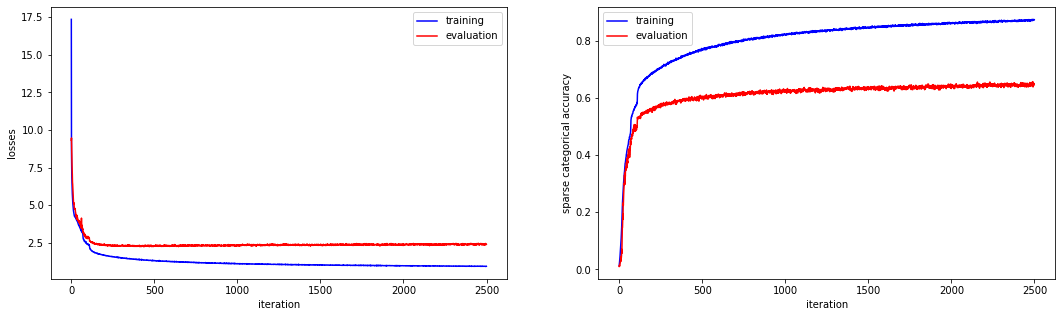

In [ ]:
import matplotlib.pyplot as plt

# plotting 
fig, axs = plt.subplots(1, 2, figsize=(18,5))
axs[0].plot(history.history['loss'], color='b', label='training')
axs[0].set(xlabel='iteration', ylabel='losses')
axs[0].plot(history.history['val_loss'], color='r', label='evaluation')
axs[0].legend()
axs[1].plot(history.history['accuracy'], color='b', label='training')
axs[1].plot(history.history['val_accuracy'], color='r', label='evaluation')
axs[1].set(xlabel='iteration', ylabel='sparse categorical accuracy')
axs[1].legend()

The following model was implemented based on [this paper](https://arxiv.org/abs/1409.6070).

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, ZeroPadding2D, LeakyReLU, ReLU
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.datasets import cifar100
from tensorflow.keras import regularizers, optimizers, initializers
import numpy as np

(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std  = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test  = (x_test-mean)/(std+1e-7)

baseMapNum = 32
weight_decay = 1e-5

initializer = initializers.HeNormal

# model
inputs = tf.keras.Input(shape=(32, 32, 3))
x = ZeroPadding2D(padding=32)(inputs)

# block 1
x = Conv2D(300, (3,3), kernel_initializer=initializer(),
           kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay))(x)
x = LeakyReLU(alpha=1/3.0)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(300, (1,1), kernel_initializer=initializer(),
           kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay))(x)
x = LeakyReLU(alpha=1/3.0)(x)
x = BatchNormalization()(x)

# block 2
x = Conv2D(600, (2,2), kernel_initializer=initializer(),
           kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay))(x)
x = LeakyReLU(alpha=1/3.0)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(600, (1,1), kernel_initializer=initializer(),
           kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay))(x)
x = LeakyReLU(alpha=1/3.0)(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

# block 3
x = Conv2D(900, (2,2), kernel_initializer=initializer(),
           kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay))(x)
x = LeakyReLU(alpha=1/3.0)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(900, (1,1), kernel_initializer=initializer(),
           kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay))(x)
x = LeakyReLU(alpha=1/3.0)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# block 4
x = Conv2D(1200, (2,2), kernel_initializer=initializer(),
           kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay))(x)
x = LeakyReLU(alpha=1/3.0)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(1200, (1,1), kernel_initializer=initializer(),
           kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay))(x)
x = LeakyReLU(alpha=1/3.0)(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# block 5
x = Conv2D(1500, (2,2), kernel_initializer=initializer(),
           kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay))(x)
x = LeakyReLU(alpha=1/3.0)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(1500, (1,1), kernel_initializer=initializer(),
           kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay))(x)
x = LeakyReLU(alpha=1/3.0)(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# block 6
x = Conv2D(1800, (2,2), kernel_initializer=initializer(),
           kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay))(x)
x = LeakyReLU(alpha=1/3.0)(x)
x = BatchNormalization()(x)
x = Conv2D(1800, (1,1), kernel_initializer=initializer(),
           kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay))(x)
x = LeakyReLU(alpha=1/3.0)(x)
x = BatchNormalization()(x)

# FCL
x = Flatten()(x)
x = Dropout(0.5)(x)
outputs = keras.layers.Dense(100, activation='softmax')(x)

model = keras.Model(inputs, outputs)

#training
batch_size = 128
epochs = 200
steps = x_train.shape[0] // batch_size

boundaries = [steps*70, steps*110]
values = [0.001, 0.0005, 0.0001]
schedules = keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
opt_adam  = keras.optimizers.Adam(learning_rate=schedules)

model.summary()

# data augmentation
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset  = tf.data.Dataset.from_tensor_slices((x_test, y_test))

def process_data(image, label):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.resize(image, (38, 38))
        image = tf.image.random_crop(image, size=[32, 32, 3])
      
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)

    return image, label

train_batches = (train_dataset.shuffle(128*4)
                              .map(process_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                              .batch(batch_size)
                              .prefetch(tf.data.experimental.AUTOTUNE) )

test_dataset = (test_dataset.batch(batch_size))

model.compile(loss='sparse_categorical_crossentropy', optimizer=opt_adam, metrics=['accuracy'])
history = model.fit(train_batches, validation_data=test_dataset, epochs=epochs, verbose=1)

169009152/169001437 [==============================] - 6s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 96, 96, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 94, 94, 300)       8400      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 94, 94, 300)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 94, 94, 300)       1200      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 300)       0         
____________________________________________________________

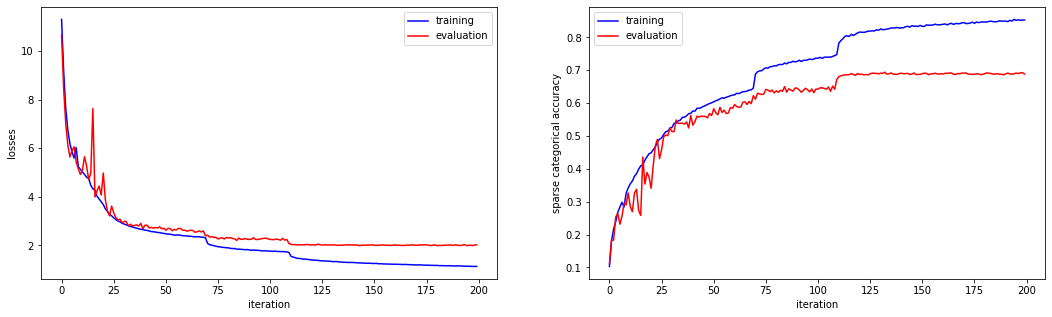

In [ ]:
import matplotlib.pyplot as plt

# plotting 
fig, axs = plt.subplots(1, 2, figsize=(18,5))
axs[0].plot(history.history['loss'], color='b', label='training')
axs[0].set(xlabel='iteration', ylabel='losses')
axs[0].plot(history.history['val_loss'], color='r', label='evaluation')
axs[0].legend()
axs[1].plot(history.history['accuracy'], color='b', label='training')
axs[1].plot(history.history['val_accuracy'], color='r', label='evaluation')
axs[1].set(xlabel='iteration', ylabel='sparse categorical accuracy')
axs[1].legend()